In [1]:
%load_ext autoreload
%autoreload 2

import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '2'
%cd ..

/home/ext-daniel-packer/documents/noteboooks/equivariant-attention


In [2]:
from models import rotation_attention, positional_encodings, vanilla_attention
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib import colormaps, animation
rng = jax.random.PRNGKey(seed=5)
rngs = jax.random.split(rng, 10)

In [39]:
n_samples = 10
n_keys = 5
n_group_samples = 10
d = 2

key_reps = rotation_attention.group_samples(n_group_samples, 1)

value_reps = rotation_attention.group_samples(n_group_samples, 0)
keys = jax.random.normal(rngs[1], shape = [n_keys, d + 1])
values = jax.random.normal(rngs[2], shape = [n_keys, d])

X_train = positional_encodings.uniform_ball_samples(rngs[0], n_samples, d = d, r = 1.)
X_train_encoded = positional_encodings.positional_encoding(X_train, method = "stereographic")

X_test = positional_encodings.uniform_ball_samples(rngs[1], n_samples * 10, d = d, r = 1.)
X_test_encoded = positional_encodings.positional_encoding(X_test, method = "stereographic")

rotation = rotation_attention.group_samples(260, 0)[57]
f = lambda x : rotation @ x * jnp.linalg.norm(x)


Y_train = jax.vmap(f)(X_train)
Y_train += jax.random.normal(rngs[2], shape=Y_train.shape) * 0.1

Y_test = jax.vmap(f)(X_test)

In [40]:
stereographic_encoding = lambda v: positional_encodings.positional_encoding(
    v, method="stereographic"
)
n_epochs = 5_000

eq_keys_hist, eq_values_hist, key_reps, value_reps, eq_betas_hist = rotation_attention.train(
    rngs[3],
    X_train,
    stereographic_encoding,
    n_keys,
    n_group_samples,
    n_epochs=n_epochs,
    lr=1.0,
    Y_train=Y_train, 
    verbose=True,
    init_beta = 1.
)

  0%|          | 0/5000 [00:00<?, ?it/s]

[None, None, Text(0.5, 1.0, 'Mean Squared Error')]

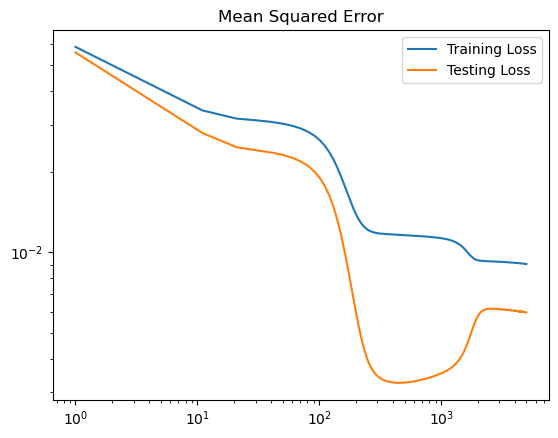

In [41]:
eq_train_loss_hist = rotation_attention.batched_loss(
    X_train_encoded,
    Y_train,
    eq_keys_hist[1::10],
    key_reps,
    eq_values_hist[1::10],
    value_reps,
    eq_betas_hist[1::10],
)

eq_test_loss_hist = rotation_attention.batched_loss(
    X_test_encoded,
    Y_test,
    eq_keys_hist[1::10],
    key_reps,
    eq_values_hist[1::10],
    value_reps,
    eq_betas_hist[1::10],
)


fig, ax = plt.subplots()

ax.plot(jnp.arange(1, eq_keys_hist.shape[0], 10), eq_train_loss_hist, label = "Training Loss")
ax.plot(jnp.arange(1, eq_keys_hist.shape[0], 10), eq_test_loss_hist, label = "Testing Loss")
ax.legend()
ax.set(xscale="log", yscale="log", title="Mean Squared Error")

In [42]:
gs = rotation_attention.group_samples(n_group_samples, 0)
X_train_aug = jnp.reshape(jnp.sum(gs[None, :, :, :] * X_train[:, None, None, :], axis = -1), [-1, 2])
Y_train_aug = jnp.reshape(jnp.sum(gs[None, :, :, :] * Y_train[:, None, None, :], axis = -1), [-1, 2])

vn_keys_hist, vn_values_hist, vn_beta_hist = vanilla_attention.train(rng,
                                                            stereographic_encoding(X_train_aug),
                                                            n_keys = n_keys * n_group_samples,
                                                            n_epochs = n_epochs,
                                                            lr = 1.0,
                                                            Y_train=Y_train_aug,
                                                            verbose = True,
                                                           )

  0%|          | 0/5000 [00:00<?, ?it/s]

[None, None, Text(0.5, 1.0, 'Mean Squared Error')]

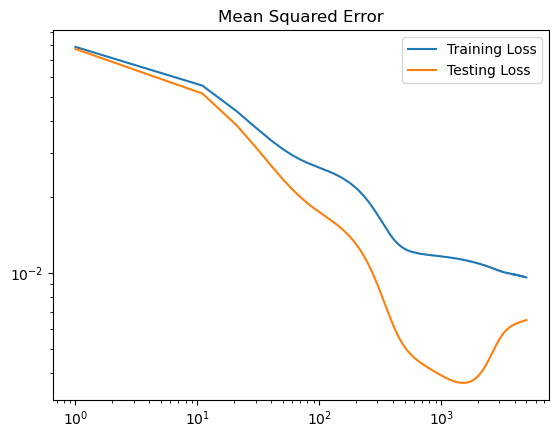

In [43]:
vn_train_loss_hist = vanilla_attention.batched_loss(
    X_train_encoded,
    Y_train,
    vn_keys_hist[1::10],
    vn_values_hist[1::10],
    vn_beta_hist[1::10],
)

vn_test_loss_hist = vanilla_attention.batched_loss(
    X_test_encoded,
    Y_test,
    vn_keys_hist[1::10],
    vn_values_hist[1::10],
    vn_beta_hist[1::10],
)

fig, ax = plt.subplots()

ax.plot(jnp.arange(1, vn_keys_hist.shape[0], 10), vn_train_loss_hist, label = "Training Loss")
ax.plot(jnp.arange(1, vn_keys_hist.shape[0], 10), vn_test_loss_hist, label = "Testing Loss")
ax.legend()
ax.set(xscale="log", yscale="log", title="Mean Squared Error")

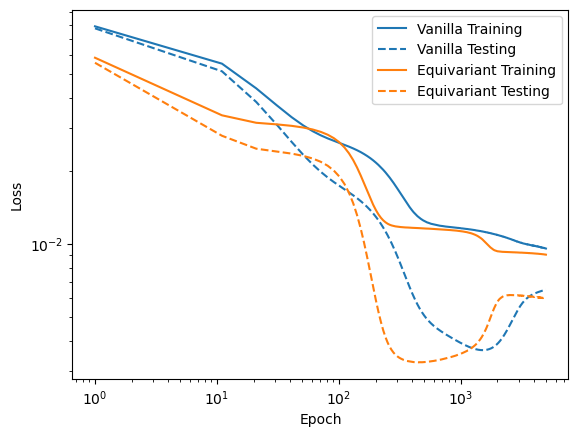

In [44]:
fig, ax = plt.subplots()

ax.plot(jnp.arange(1, vn_keys_hist.shape[0], 10), vn_train_loss_hist, color = "C0", label = "Vanilla Training")
ax.plot(jnp.arange(1, vn_keys_hist.shape[0], 10), vn_test_loss_hist, color = "C0", label = "Vanilla Testing", linestyle = "--")

ax.plot(jnp.arange(1, eq_keys_hist.shape[0], 10), eq_train_loss_hist, color = "C1", label = "Equivariant Training")
ax.plot(jnp.arange(1, eq_keys_hist.shape[0], 10), eq_test_loss_hist, color = "C1", label = "Equivariant Testing", linestyle = "--")

ax.set(xscale = "log", yscale = "log", xlabel = "Epoch", ylabel = "Loss")
ax.legend()
plt.show()

[None, Text(0.5, 0, 'Epoch')]

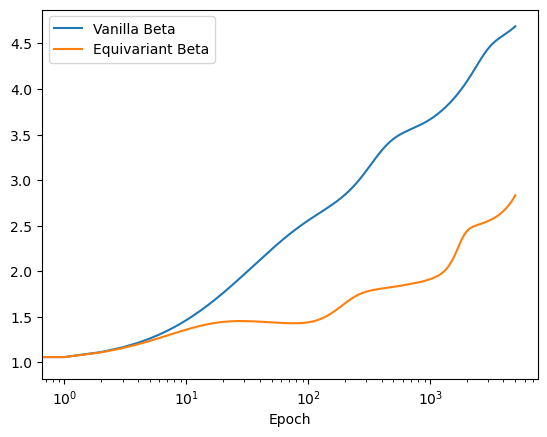

In [45]:
fig, ax = plt.subplots()

ax.plot(jnp.arange(0, vn_beta_hist.shape[0]), vn_beta_hist, color = "C0", label = "Vanilla Beta")
ax.plot(jnp.arange(0, eq_betas_hist.shape[0]), eq_betas_hist, color = "C1", label = "Equivariant Beta")

ax.legend()
ax.set(xscale="log", xlabel ="Epoch")


[None, Text(0.5, 0, 'Epoch')]

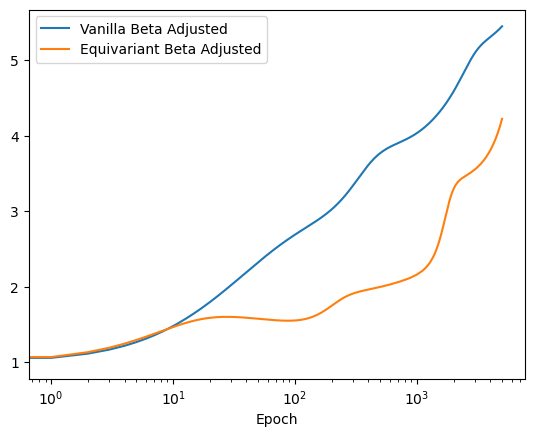

In [46]:
eq_key_norms = jnp.mean(jnp.linalg.norm(eq_keys_hist, axis = -1), axis = -1)
vn_key_norms = jnp.mean(jnp.linalg.norm(vn_keys_hist, axis = -1), axis = -1)

fig, ax = plt.subplots()

ax.plot(jnp.arange(0, vn_beta_hist.shape[0]), vn_key_norms * vn_beta_hist, color = "C0", label = "Vanilla Beta Adjusted")
ax.plot(jnp.arange(0, eq_betas_hist.shape[0]), eq_key_norms * eq_betas_hist, color = "C1", label = "Equivariant Beta Adjusted")

ax.legend()
ax.set(xscale="log", xlabel ="Epoch")

[None]

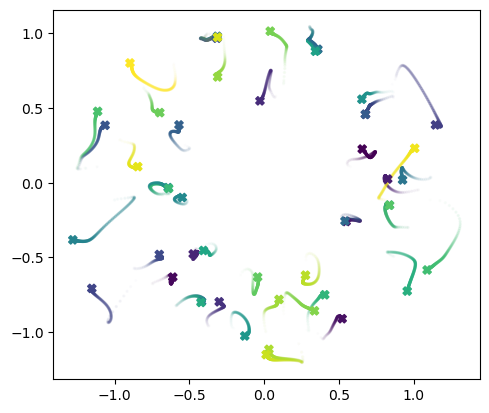

In [60]:
fig, ax = plt.subplots()
cmap = colormaps.get_cmap("viridis")

color = cmap(jnp.linspace(0, 1, num = vn_keys_hist.shape[1]))

for i in jnp.arange(0, n_epochs, 50):
    vn_keys = vn_keys_hist[i]
    ax.scatter(vn_keys[:, 0], vn_keys[:, 1], c=color, s = 2, alpha = ((i.item() / n_epochs) * 0.8))
    
ax.scatter(vn_keys[:, 0], vn_keys[:, 1], c=color, marker="X")

ax.set(aspect="equal")


[None]

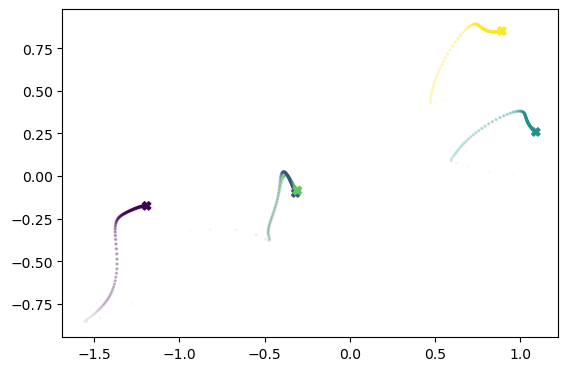

In [61]:
fig, ax = plt.subplots()
cmap = colormaps.get_cmap("viridis")

color = cmap(jnp.linspace(0, 1, num = eq_keys_hist.shape[1]))

for i in jnp.arange(0, n_epochs, 50):
    eq_keys = eq_keys_hist[i]
    ax.scatter(eq_keys[:, 0], eq_keys[:, 1], c=color, s = 2, alpha = ((i.item() / n_epochs) * 0.8))
    
ax.scatter(eq_keys[:, 0], eq_keys[:, 1], c=color, marker="X")

ax.set(aspect="equal")